# Homography Regression Qualitative Evaluation
A homography regression network that was trained on synthetically generated camera motion data is evaluated on data where camera motion occurs naturally.

## Load Model

In [2]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from kornia import warp_perspective, tensor_to_image
from torchvision.transforms import ToTensor
import sys

sys.path.append('../')

from datasets import ImageSequenceDataset
from lightning_modules import DeepImageHomographyEstimationModuleBackbone
from utils.io import load_yaml
from utils.processing import imageEdges, fourPtToMatrixHomographyRepresentation
from utils.viz import yt_alpha_blend

In [1]:
# load best model\n",
prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_2'
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/unsupervised_deep_homography_estimation_backbone/version_0'
configs = load_yaml(os.path.join(prefix, 'configs.yml'))
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, 'checkpoints/epoch=49.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'

model.to(device)
model = model.eval()

# create dataset and evaluate model on
#   - with motion dataset
#   - cholec80
def forward_model(img_seq):
    img_seq[0], img_seq[1] = img_seq[0].to(device).squeeze(), img_seq[1].to(device).squeeze()
    duv = model(img_seq[0].unsqueeze(0), img_seq[1].unsqueeze(0))

    uv = imageEdges(img_seq[0].unsqueeze(0))
    H = fourPtToMatrixHomographyRepresentation(uv, duv)

    wrp = warp_perspective(img_seq[0].unsqueeze(0), torch.inverse(H), img_seq[0].shape[-2:])
    return wrp, H, duv

def eval(img_seq, init_frame=None, init=False, h_memory=torch.eye(3).unsqueeze(0), shape=(640, 480), show_image=True, track=False):
    wrp, H, _ = forward_model(img_seq)

    wrp = cv2.resize(tensor_to_image(wrp), shape)[...,::-1]
    img0 = cv2.resize(tensor_to_image(img_seq[0]), shape)[...,::-1]
    img1 = cv2.resize(tensor_to_image(img_seq[1]), shape)[...,::-1]

    l1_img0_img1 = abs(img1-img0)
    l1_img1_wrp  = abs(img1-wrp)
    blend_img0_img1 = yt_alpha_blend(img1, img0)
    blend_img1_wrp  = yt_alpha_blend(img1, wrp)

    if track:
        if not init:
            init_frame = cv2.resize(tensor_to_image(img_seq[0]), shape)[...,::-1]
            init = True

        h_memory = h_memory.matmul(H.detach()) # inverse ordertensor_to_image

        wrp_memory = warp_perspective(img_seq[1].unsqueeze(0), h_memory, img_seq[1].shape[-2:])
        wrp_memory = cv2.resize(tensor_to_image(wrp_memory), shape)[...,::-1]

        blend_wrp_memory_init_frame  = yt_alpha_blend(wrp_memory, init_frame)
        top_row    = np.concatenate([img0, l1_img0_img1, blend_img0_img1], axis=1)
        bottom_row = np.concatenate([blend_wrp_memory_init_frame,  l1_img1_wrp,  blend_img1_wrp], axis=1)
    else:
        top_row    = np.concatenate([img0, l1_img0_img1, blend_img0_img1], axis=1)
        bottom_row = np.concatenate([img1,  l1_img1_wrp,  blend_img1_wrp], axis=1)
    composite = np.concatenate([top_row, bottom_row], axis=0)

    if show_image:
        cv2.imshow('composite', composite)
        cv2.waitKey()

    if track:
        return composite, init_frame, init, h_memory
    else:
        return composite

NameError: name 'load_yaml' is not defined

## With Camera Motion - DaVinci

In [2]:
# motion dataset
prefix = '/media/martin/Samsung_T5/data/endoscopic_data/camera_motion_separated_png/with_camera_motion'
df_name = 'log_with_camera_motion_seq_len_2.pkl'
df = pd.read_pickle(os.path.join(prefix, df_name))
ds = ImageSequenceDataset(df, prefix, ToTensor())
dl = DataLoader(ds, batch_size=1)

init_frame = None
init = False
h_memory = torch.eye(3, device=device)
for img_seq in dl: 
    composite, init_frame, init, h_memory = eval(img_seq, init_frame, init, h_memory, show_image=True, track=True)

## With Camera Motion - Cholec80
### Image Shapes

In [2]:
# cholec80, analyze image shape
cholec_configs = load_yaml('configs/cholec80_transforms.yml')

database_prefix = '/media/martin/Samsung_T5/data/endoscopic_data'

for database in cholec_configs['databases']:
    path = os.path.join(database_prefix, database['prefix'])
    for file in database['videos']['files']:
        path = os.path.join(database_prefix, database['prefix'], database['videos']['prefix'], file)
        vc = cv2.VideoCapture(path)

        _, img = vc.read()
        cv2.imshow('img', img)
        cv2.waitKey()

### Homography Estimation

In [2]:
# cholec80, evaluate model
prefix = '/media/martin/Samsung_T5/data/endoscopic_data/tmp'
df_name = 'cholec80_seq_len_2.pkl'
df = pd.read_pickle(os.path.join(prefix, df_name))
ds = ImageSequenceDataset(df, prefix, ToTensor())
dl = DataLoader(ds, batch_size=1)

# 44.7 s ± 419 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) (divide by 1000)
# in between ~ 22 and 50 fps
init_frame = None
init = False    
h_memory = torch.eye(3, device=device)
track = False
for img_seq in dl: 
    if track:
        composite, init_frame, init, h_memory = eval(img_seq, init_frame, init, h_memory, show_image=True, track=track)
    else:
        composite = eval(img_seq, shape=(640, 480), show_image=True)

#### Create Video

In [3]:
# cholec80, evaluate model
prefix = '/media/martin/Samsung_T5/data/endoscopic_data/tmp'
df_name = 'cholec80_seq_len_2.pkl'
df = pd.read_pickle(os.path.join(prefix, df_name))
ds = ImageSequenceDataset(df, prefix, ToTensor())
dl = DataLoader(ds, batch_size=1)

# 44.7 s ± 419 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) (divide by 1000)
# in between ~ 22 and 50 fps

shape = eval(next(iter(dl)), show_image=False, track=False).shape[:2]
out = cv2.VideoWriter('composite_stride_10.avi', fourcc=cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps=25, frameSize=(shape[1], shape[0]))

init_frame = None
init = False
h_memory = torch.eye(3, device=device).unsqueeze(0)
for img_seq in dl: 
    composite, init_frame, init, h_memory = eval(img_seq, init_frame, init, h_memory, show_image=False, track=True)
    composite = (composite*255).astype(np.uint8)
    out.write(composite)

out.release()

# Latent Space Analysis
Evaluate regularities within latent space along two dimensions
 - Time
 - Homography itself

In [27]:
# cholec80, extarct features
prefix = '/media/martin/Samsung_T5/data/endoscopic_data/tmp'
df_name = 'cholec80_seq_len_2.pkl'
df = pd.read_pickle(os.path.join(prefix, df_name))
ds = ImageSequenceDataset(df, prefix, ToTensor())
dl = DataLoader(ds, batch_size=1)

# extract features from model
activation = {} # https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.model.avgpool.register_forward_hook(get_activation('avgpool'))

feature_df = pd.DataFrame(columns=['t', 'duv', 'H', 'feature'])

for idx, img_seq in enumerate(dl):
    wrp, H, duv = forward_model(img_seq)

    feature_df = feature_df.append({
        't': idx,
        'duv': duv.squeeze().detach().cpu().numpy(),
        'H': H.squeeze().detach().cpu().numpy(),
        'feature': activation['avgpool'].squeeze().detach().cpu().numpy()
    }, ignore_index=True)
    

feature_df.to_csv('cholec80_img_seq_features.csv')
feature_df.to_pickle('cholec80_img_seq_features.pkl')

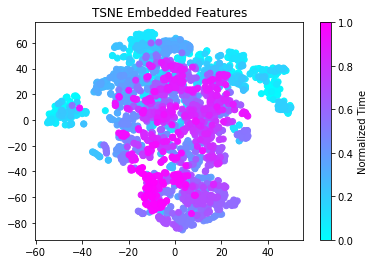

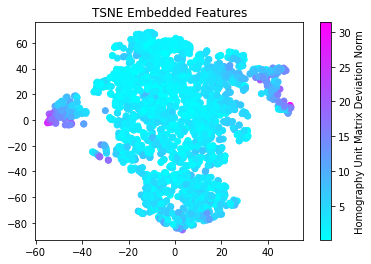

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

feature_df = pd.read_pickle('cholec80_img_seq_features.pkl')
t = list(feature_df['t']/feature_df['t'].iloc[-1])
features = list(feature_df['feature'])
embedded_features = TSNE(n_components=2, random_state=42).fit_transform(features)

plt.title('TSNE Embedded Features')
plt.scatter(x=embedded_features[:,0], y=embedded_features[:,1], c=t, cmap='cool')
cbar = plt.colorbar()
cbar.set_label('Normalized Time')
plt.show()

plt.title('TSNE Embedded Features')
dH_norm = feature_df['H'].apply(lambda x: np.linalg.norm(x - np.eye(3)))
plt.scatter(x=embedded_features[:,0], y=embedded_features[:,1], c=dH_norm, cmap='cool')
cbar = plt.colorbar()
cbar.set_label('Homography Unit Matrix Deviation Norm')
plt.show()

# Motion Severity Analysis
Evaluation of the norm of homographies over time 

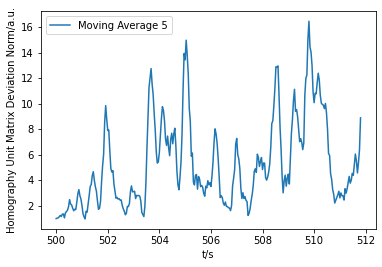

In [6]:
# feature_df = pd.read_pickle('cholec80_img_seq_features.pkl')
feature_df = pd.read_pickle('H.pkl')

fps = 25
start = 500
end = 512

N = 5
t = feature_df['t'][int(fps*start):int(fps*end)]/fps
H = feature_df['H'][int(fps*start):int(fps*end)]
# t = feature_df['t']/fps
# H = feature_df['H']
# t = feature_df['t'][0:100]/fps
# H = feature_df['H'][0:100]

# compute severity of motion
dH_norm = H.apply(lambda x: np.linalg.norm(x - np.eye(3)))

# compute moving average
ma_dH_norm = np.convolve(dH_norm, np.ones(N)/N, mode='valid')

plt.plot(t[:ma_dH_norm.shape[0]], ma_dH_norm, label='Moving Average {}'.format(N))
# plt.plot(t[N:dH_norm.shape[0]], dH_norm[N:], label='Homography')
plt.xlabel('t/s')
plt.ylabel('Homography Unit Matrix Deviation Norm/a.u.')
plt.legend()
plt.show()